In [1]:
import torch
import numpy as np
import pandas as pd
from ast import literal_eval
from collections import Counter

from sklearn.metrics import adjusted_rand_score, silhouette_score, confusion_matrix
from sklearn.cluster import KMeans, AgglomerativeClustering

import umap
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

from utils import load_data
from utils import path_config as config

/home/chistik/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
en_df = pd.read_csv('en_df.csv', converters={'text': literal_eval, 'terms': literal_eval})
ru_df = pd.read_csv('ru_df.csv', converters={'text': literal_eval, 'terms': literal_eval})
en_themes = en_df['theme'].tolist()
ru_themes = ru_df['theme'].tolist()

In [3]:
sum=0
for item in Counter(en_themes).most_common(10):
    sum+=item[1]
sum

1480

In [4]:
sum=0
for item in Counter(ru_themes).most_common(10):
    sum+=item[1]
sum

1784

In [5]:
def standardize(embeddings):
    mean = np.mean(embeddings, axis=0)
    std_dev = np.std(embeddings, axis=0)
    standardized_embeddings = (embeddings - mean) / std_dev
    return standardized_embeddings

In [6]:
def clustering_analysis(model_name):
    contextualized_sentence_embeddings, theme_labels = load_data(torch.load(config[model_name]), data_type= 'sentence', language='en')

    label_list=set(theme_labels)
    label_to_id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label_to_id.items()}
    labels = np.array([label_to_id[label] for label in theme_labels])
    umap_reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=40, min_dist=0.2, metric='euclidean') 
    reduced_embeddings = umap_reducer.fit_transform(contextualized_sentence_embeddings)

    def plot_umap_results(embeddings, labels, title):
        unique_labels = np.unique(labels)
        num_labels = len(unique_labels)
        colors = sns.color_palette('tab10', n_colors=num_labels)
        label_to_color = dict(zip(unique_labels, colors))
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        label_colors = [label_to_color[l] for l in labels]
        ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=label_colors)
        ax.set_title(title)
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        handles = [plt.Line2D([0], [0], marker='o', color=color, label=id2label[label]) for label, color in label_to_color.items()]
        ax.legend(handles=handles, title='Theme Label', bbox_to_anchor=(1.15, 1), loc='upper left')
        plt.show()

    def plot_tsne_results(embeddings, labels, title):
        unique_labels = np.unique(labels)
        num_labels = len(unique_labels)
        colors = sns.color_palette('tab10', n_colors=num_labels)
        label_to_color = dict(zip(unique_labels, colors))
        
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        label_colors = [label_to_color[l] for l in labels]
        ax.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=label_colors)
        
        ax.set_title(title)
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.set_zlabel('Dimension 3')
        
        handles = [plt.Line2D([0], [0], marker='o', color=color, label=id2label[label]) for label, color in label_to_color.items()]
        ax.legend(handles=handles, title='Label', bbox_to_anchor=(1.15, 1), loc='upper left')
        
        plt.show()


    plot_umap_results(reduced_embeddings, labels, f'UMAP Embeddings Visualization with Theme Labels ({model_name})')
   
    tsne = TSNE(n_components=3, random_state=100, perplexity=40)
    embeddings_3d = tsne.fit_transform(np.array(contextualized_sentence_embeddings))

    plot_tsne_results(embeddings_3d, labels, f't-SNE Embeddings Visualization with Theme Labels ({model_name})')

    n_clusters = 10  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(reduced_embeddings)

    kmeans_ari = adjusted_rand_score(labels, kmeans_labels)
    silhouette_kmeans = silhouette_score(reduced_embeddings, kmeans_labels)
    print(f"KMeans Adjusted Rand Index (ARI): {kmeans_ari:.4f}")
    print(f"KMeans Silhouette Score: {silhouette_kmeans:.4f}")

    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_labels = agglo.fit_predict(reduced_embeddings)

    agglo_ari = adjusted_rand_score(theme_labels, agglo_labels)
    silhouette_agglo = silhouette_score(reduced_embeddings, agglo_labels)
    print(f"Agglomerative Clustering Adjusted Rand Index (ARI): {agglo_ari:.4f}")
    print(f"Agglomerative Clustering Silhouette Score: {silhouette_agglo:.4f}")


    def plot_confusion_matrix(confusion_mat, clustering_name, model_name):
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f'Cluster {i}' for i in range(confusion_mat.shape[1])],
                    yticklabels=[f'{id2label[i]}' for i in range(confusion_mat.shape[0])])
        plt.title(f'{clustering_name} Confusion Matrix ({model_name})')
        plt.xlabel('Predicted Cluster')
        plt.ylabel('Theme')
        plt.show()

    def compare_results(cluster_labels, true_labels, clustering_name):
        confusion = confusion_matrix(true_labels, cluster_labels)
        plot_confusion_matrix(confusion, clustering_name, model_name)

    compare_results(kmeans_labels, labels, 'KMeans')
    compare_results(agglo_labels, labels, 'Agglomerative Clustering')

/ibex/user/chistik/conda-environments/py39/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


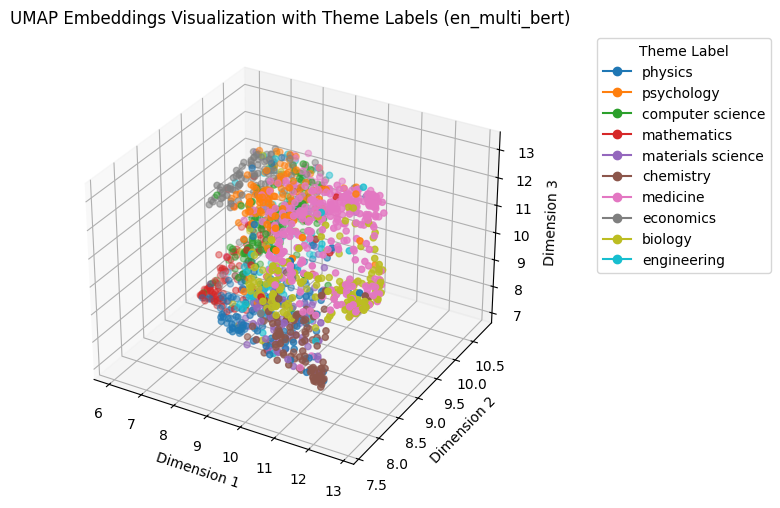

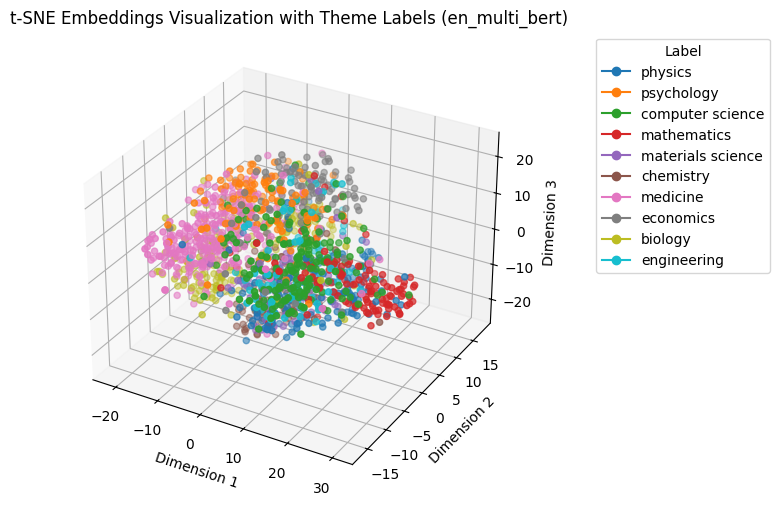

KMeans Adjusted Rand Index (ARI): 0.3373
KMeans Silhouette Score: 0.3805
Agglomerative Clustering Adjusted Rand Index (ARI): 0.3262
Agglomerative Clustering Silhouette Score: 0.3403


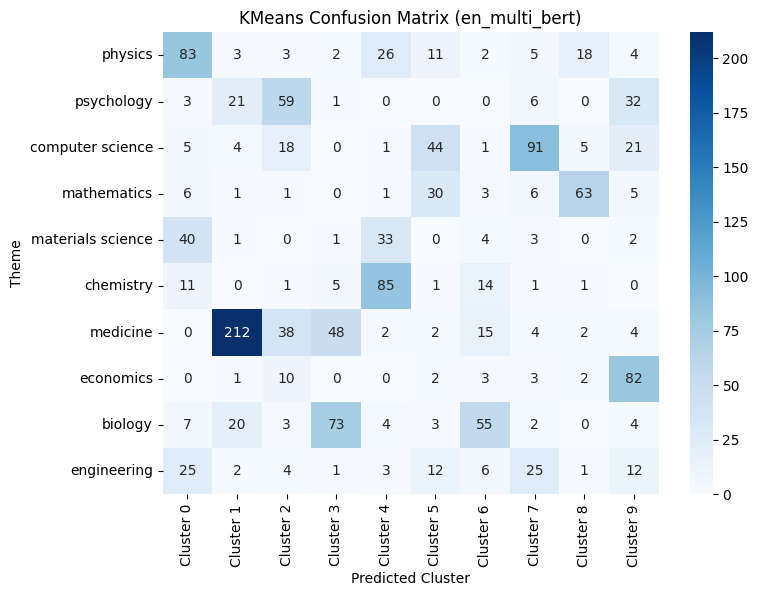

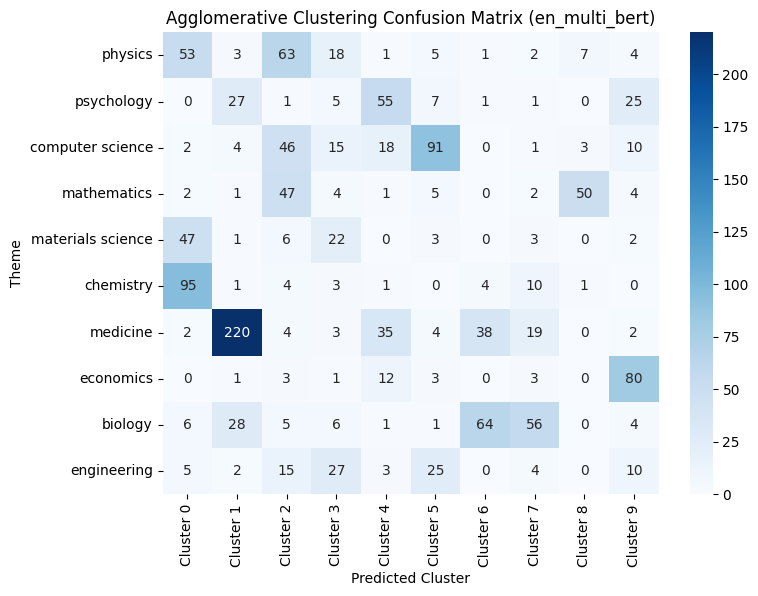

In [7]:
clustering_analysis('en_multi_bert')

/ibex/user/chistik/conda-environments/py39/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


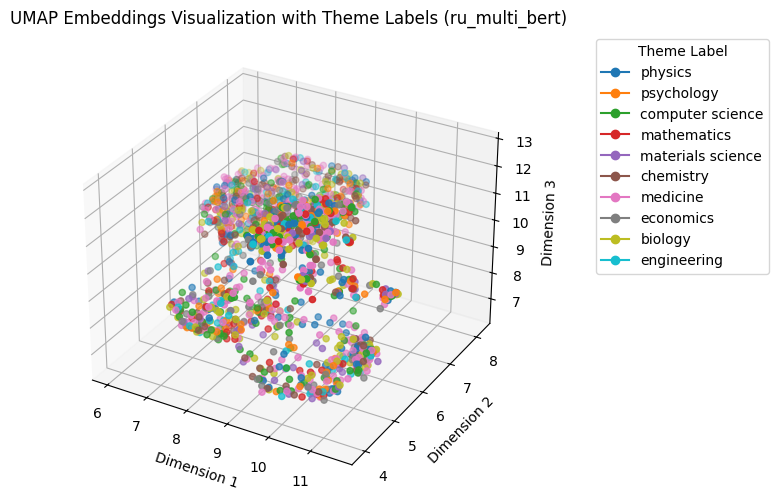

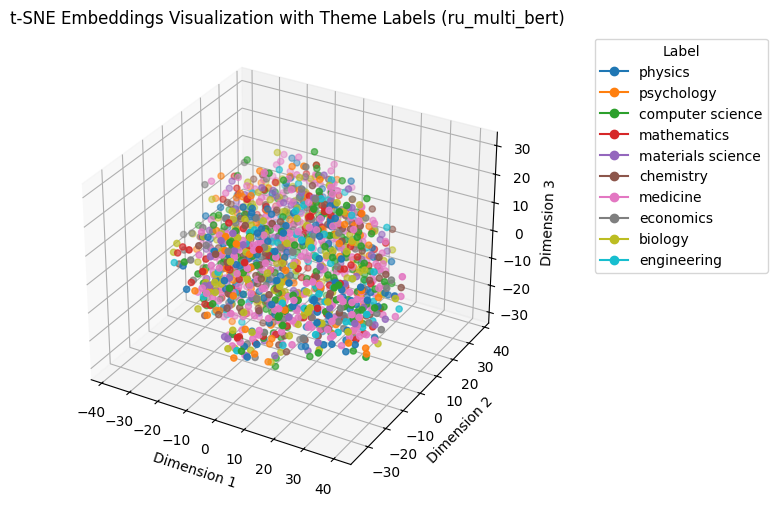

KMeans Adjusted Rand Index (ARI): 0.0017
KMeans Silhouette Score: 0.3705
Agglomerative Clustering Adjusted Rand Index (ARI): 0.0017
Agglomerative Clustering Silhouette Score: 0.3538


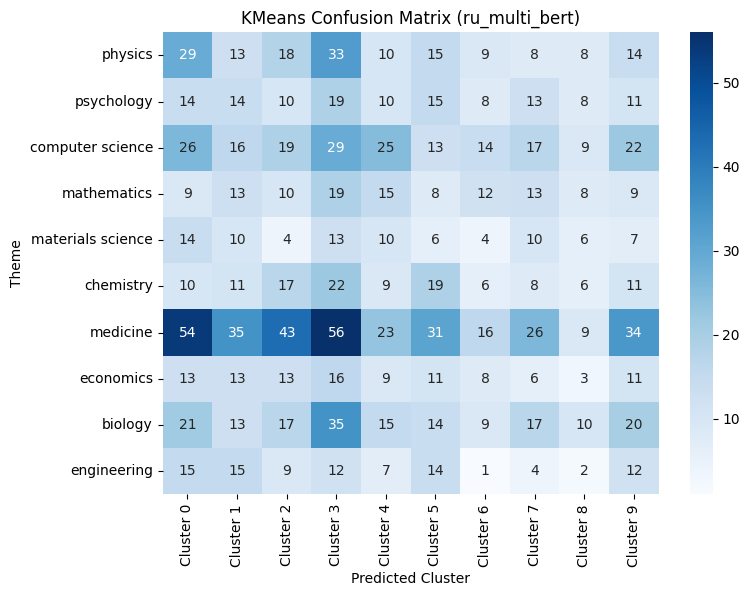

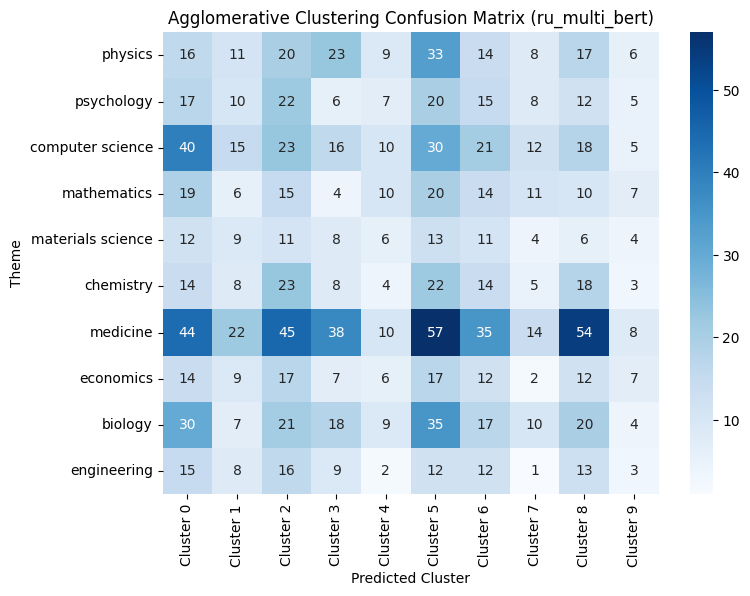

In [8]:
clustering_analysis('ru_multi_bert')

/ibex/user/chistik/conda-environments/py39/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


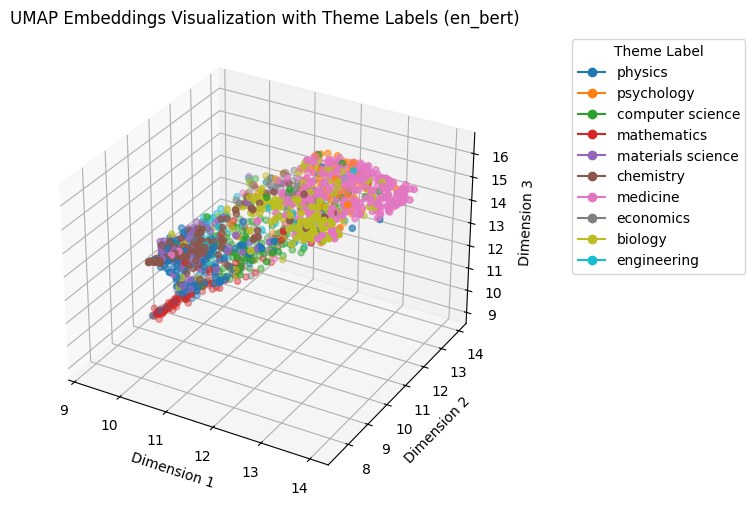

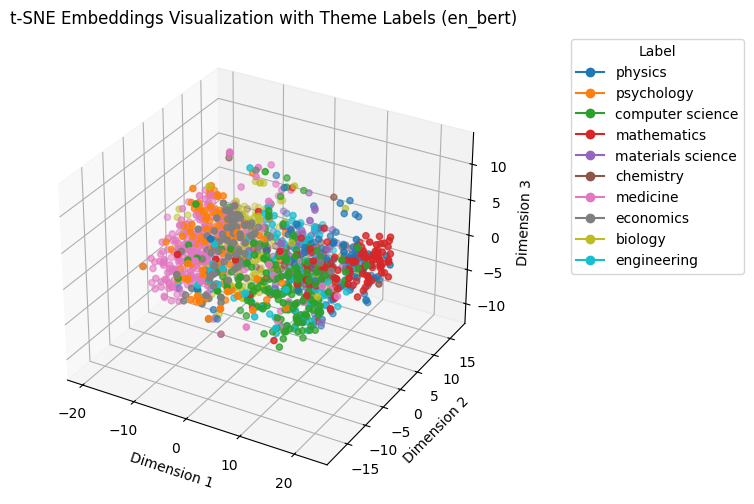

KMeans Adjusted Rand Index (ARI): 0.3038
KMeans Silhouette Score: 0.3772
Agglomerative Clustering Adjusted Rand Index (ARI): 0.2772
Agglomerative Clustering Silhouette Score: 0.3545


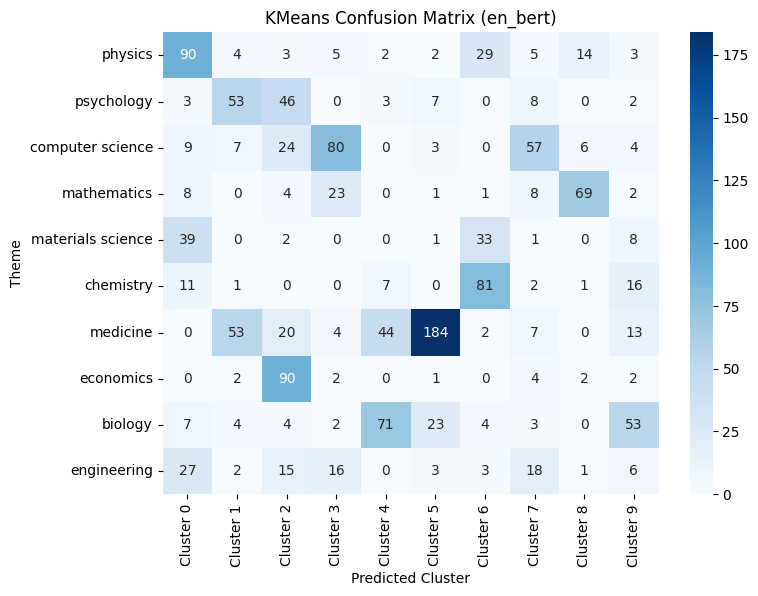

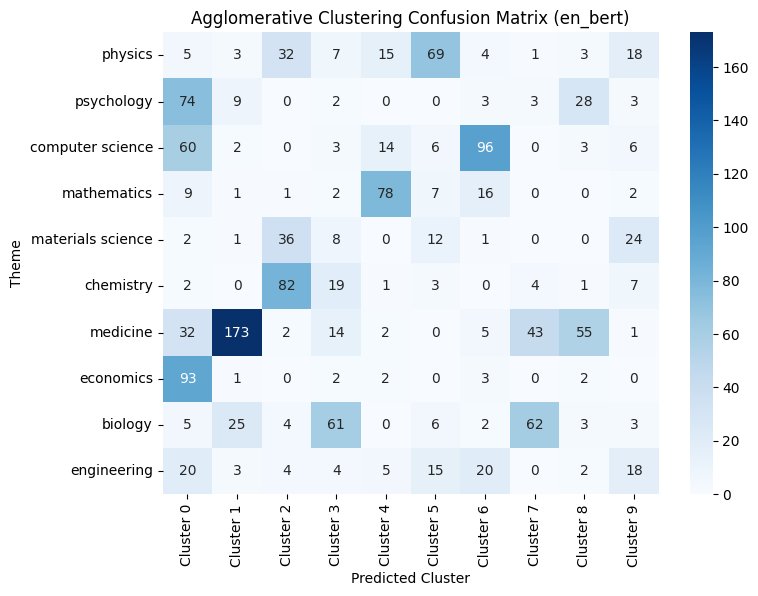

In [9]:
clustering_analysis('en_bert')

/ibex/user/chistik/conda-environments/py39/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


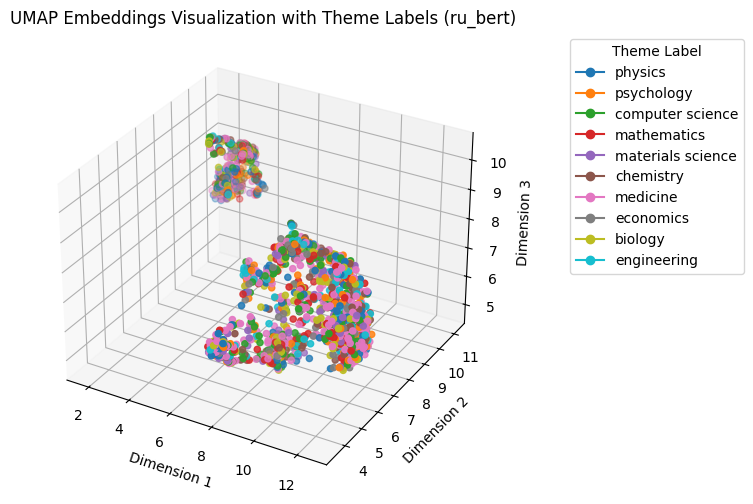

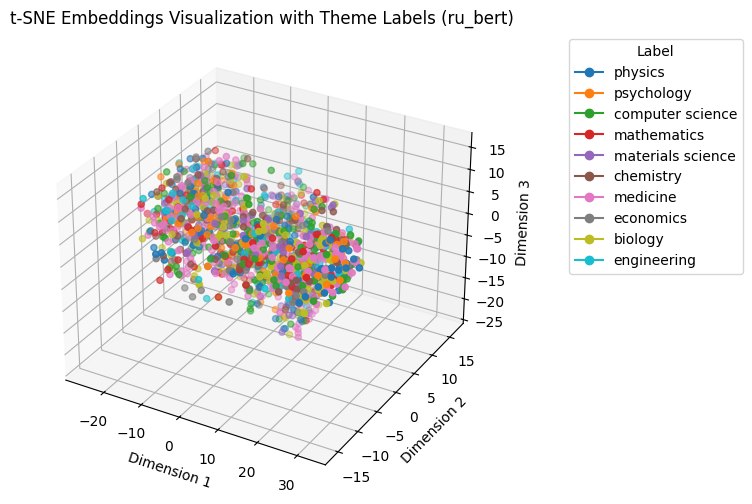

KMeans Adjusted Rand Index (ARI): 0.0033
KMeans Silhouette Score: 0.4480
Agglomerative Clustering Adjusted Rand Index (ARI): 0.0047
Agglomerative Clustering Silhouette Score: 0.4184


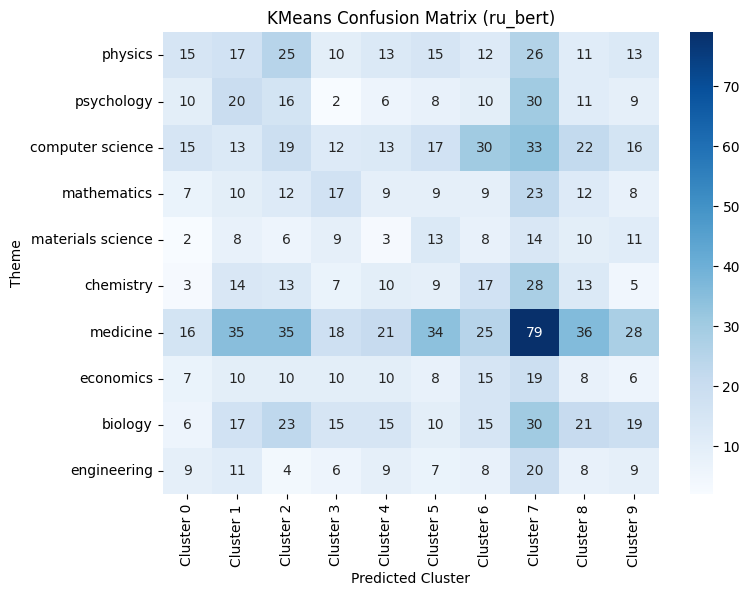

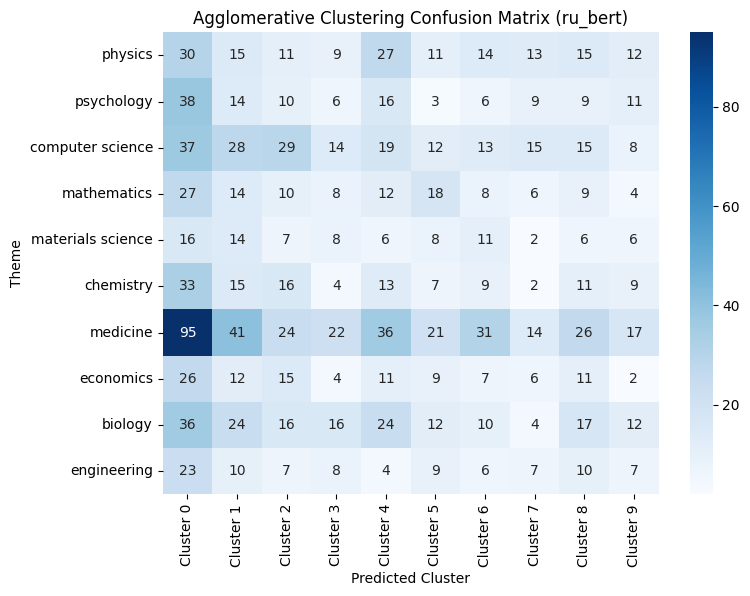

In [10]:
clustering_analysis('ru_bert')

/ibex/user/chistik/conda-environments/py39/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


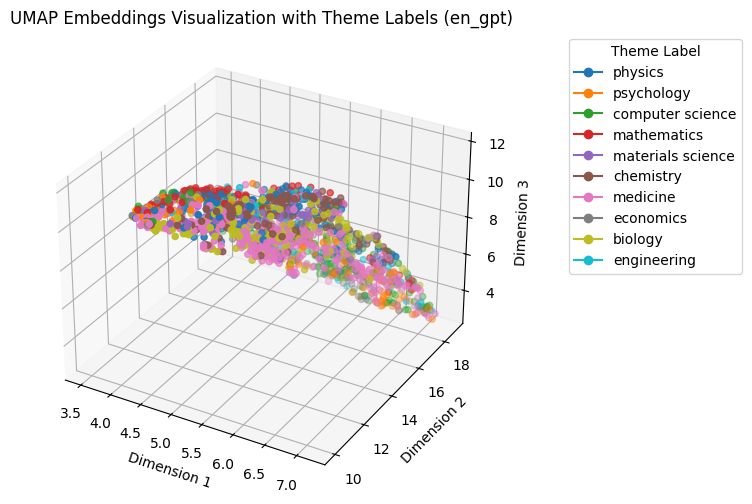

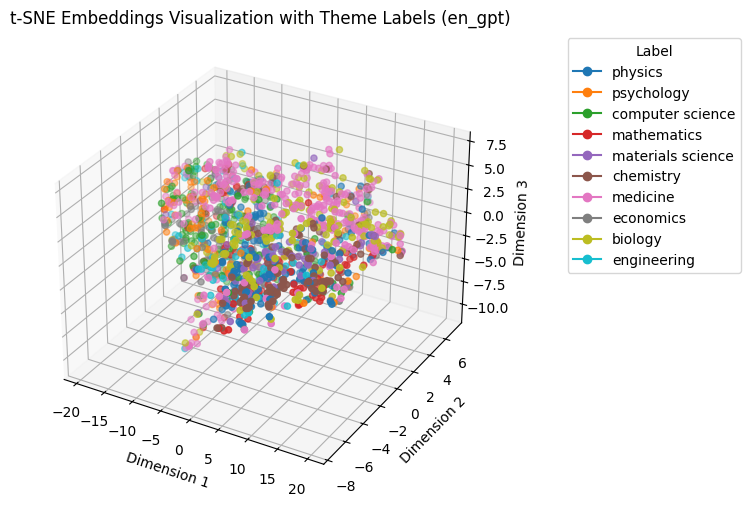

KMeans Adjusted Rand Index (ARI): 0.0506
KMeans Silhouette Score: 0.3387
Agglomerative Clustering Adjusted Rand Index (ARI): 0.0502
Agglomerative Clustering Silhouette Score: 0.2667


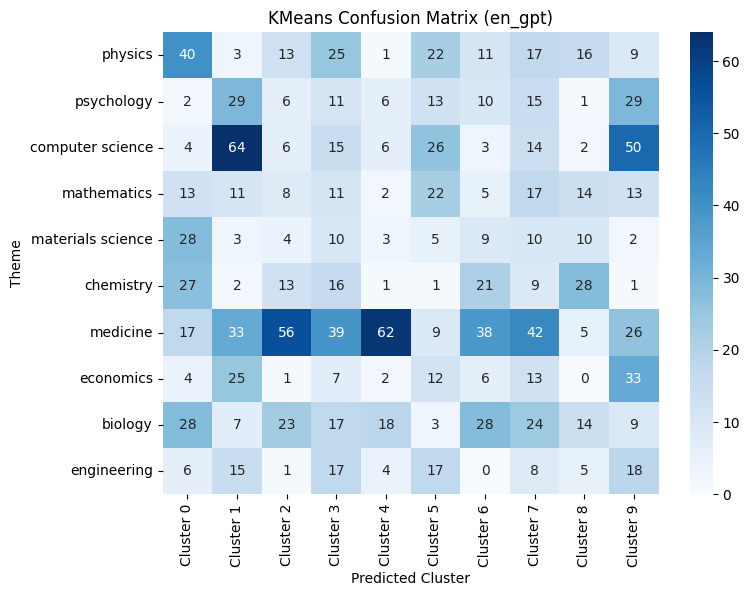

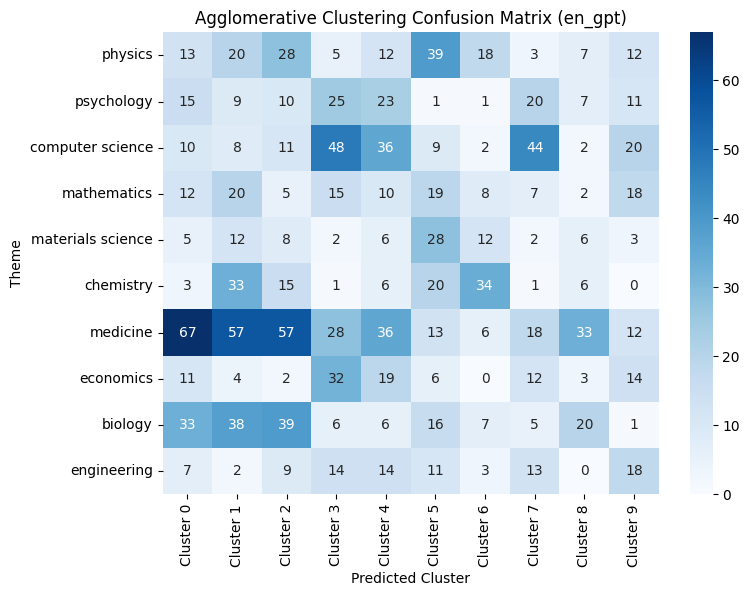

In [11]:
clustering_analysis('en_gpt')

/ibex/user/chistik/conda-environments/py39/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


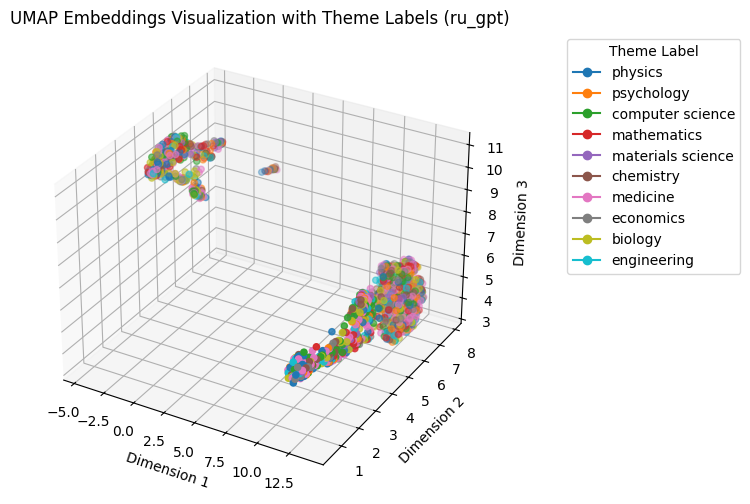

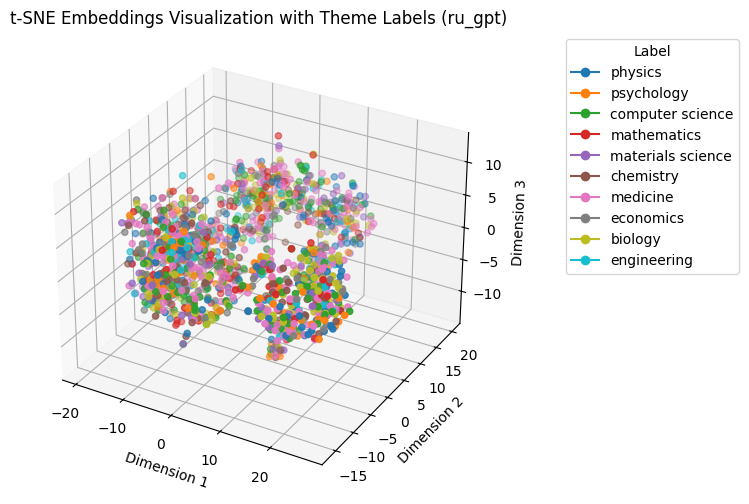

KMeans Adjusted Rand Index (ARI): 0.0014
KMeans Silhouette Score: 0.4443
Agglomerative Clustering Adjusted Rand Index (ARI): 0.0005
Agglomerative Clustering Silhouette Score: 0.3726


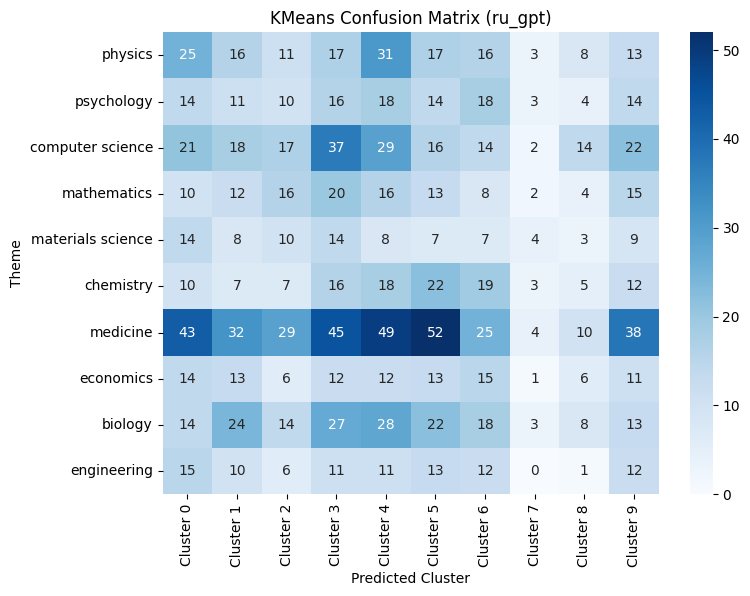

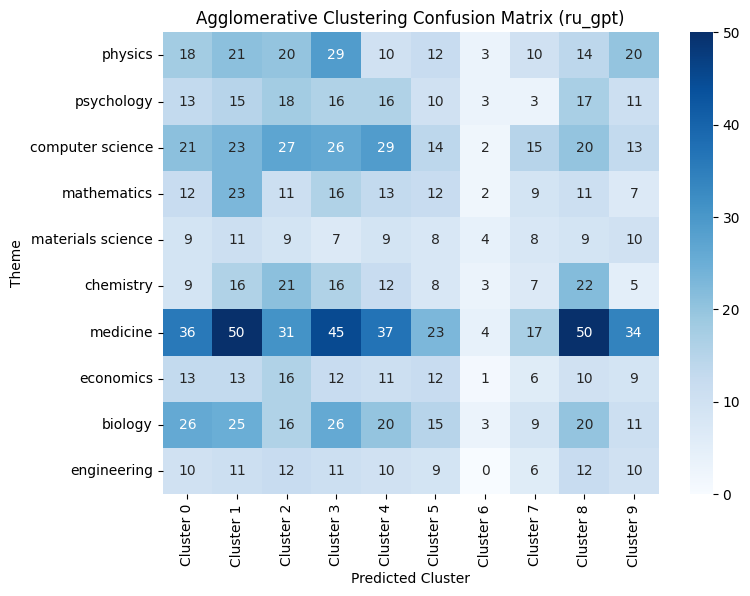

In [12]:
clustering_analysis('ru_gpt')